<a href="https://colab.research.google.com/github/amareyah/MaxinAI_Education/blob/master/dl_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fastai2

     |████████████████████████████████| 194kB 2.7MB/s 


In [ ]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchvision.models import resnext101_32x8d, resnet50, vgg16

import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
def cnn_dim(in_shape, ker_shape, stride, padding):
    """
    Calculate output dimension of the convolutional layer
    Args:
       in_shape: input shape - height or width
       ker_shape: kernel shape - height or width
       stride: stride
       padding: padding
    
    Returns:
        output dimension of convolutional layer
    """
    out_shape = (in_shape - ker_shape + 2 * padding) / stride + 1
    out_shape = int(out_shape)
    
    return out_shape

out_dim = cnn_dim(224, 3, 1, 1)
print(f'out_dim = {out_dim}')

out_dim = 224


In [ ]:
vgg16_model = vgg16(pretrained=True)
vgg16_model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
resnet50_model = resnet50(pretrained=True)
resnet50_model

In [ ]:
resnext101_32x8d_model = resnext101_32x8d(pretrained=True)
resnext101_32x8d_model

There are different ResNet models:
- ResNet18
- ResNet34
- ResNet50
- ResNet101
- ResNet1001

Inception-ResNet
- Inception-ResNet A Block
- Inception-ResNet B Block
- Inception-ResNet C Block
- Reduction A Block
- Reduction B Block

ResNeXt architectures:
- ResNext50_32X4d
- ResNext50_64X4d
- ResNext101_32X4d
- ResNext101_64X4d

Other architectures
- DenceNet
- TraceNet
- EfficientNet

see details in **lecture_16_convolutional_neural_networks.ipynb**

**Global Average Pooling Layer:**  For each feature map takes the average value of all nodes and maps that value to one node. Number of in_channels = Number of out_channels.

**Adaptive Average Pooling Layer:**
For each feature map applies a 2D adaptive average pooling over an input signal. The output is of size H x W, **for any input size**. The number of output features is equal to the number of input planes.

## Feature extraction / embedding
Let's take one of the pre-trained (on ImageNet) models, VGG, Inception, ResNet, etc and remove all the last layers before convolutional layers:

- For VGG16 remove last two fully connected layers
- For Inception and ResNet remove all the layer after adaptive (global) average pooling

So our model generates vector from the image

In [ ]:
net = vgg16_model
net

In [ ]:
model = nn.Sequential(*list(net.children())[:-1])
model

In [ ]:
x = torch.randn(1, 3, 399, 399)
with torch.no_grad():
    y1 = net(x)
    y2 = model(x)

In [ ]:
y1.size()

In [ ]:
y2.size()

In [ ]:
y2 = torch.flatten(y2, 1)
y2.size()

So we have $2048$ dimensional vectors, we can run our model on the our dataset of images and generate $2048$ dimensional vectors.
$$
f: \mathbb{R}^{3 \times H \times W} \mapsto \mathbb{R}^d
$$
<br>
Our model maps each $C \times H \times W$ (they might be different for adaptive average pooling) dimensional image to the fixed $d$ dimensional vector. 

Vectors have "distance" property.
<br>
If we store this vectors and run **K-nearest neighbor** search we can observe that similarity search is working even if our dataset was not used during the training.
<br>
Note: Search results depend on model and domain of training set and dataset
<br>

Last layer **Dimensionality Reduction**

**Visualize the space of feature vectors** by reducing dimensionality of vectors from 4096 to 2 dimensions.
Simpple algorith: **Principle Component Analysis (PCA)**
More comlex: **t-SNE**

## Transfer-learning

We can see that first layers extract essential features which are pretty similar for all images. Second layers extract more complex features and last layers more domain-specific features
Can we use this information for different task. Would it be enough information, enough features if use it pre-trained model on the different dataset?

With the following approach:
- We extract features from the images with the pre-trained model
- Train different model with this features

Turns out that this approach works and it's called transfer earning. For transfer learning we should consider the following:
- Is the model is trained on the similar domain
- Is the model trained on the enough data

The state-of-the art result achieved with model trained on ImageNet classification task:
- It has different and well-distributed images
- More precise labeled
- Or it has enough images to extract "all-possible" features

There are several approaches:
- Use extracted features and train different model
- Freeze the weights and train only classifier
- Fine-tune whole model with discriminative learning rates

First approach needs pre-extraction of the feature vectors and training different model on them:

- Extract features
- Train different classifier (SVM, RF, GB) on them

For the second approach we put our layers on top the model and train it:
- Put custom layers on model
- Freeze feature extraction layers weights
- Train custom layer

In [ ]:
model_fn = nn.Sequential(*list(model.children()) + [nn.Linear(25088, 500), nn.Dropout(p=0.3), nn.Linear(500, 20)])
model_fn

For third approach, we put our layers on top the model and train it with different learning rate:

- Put custom layers on model
- Train full model using larger learning rate for last layers, smaller maybe  $\frac{1}{100}$  for the middle layers and  $\frac{1}{1000}$  for the first layers.

Pre-trained classifier also used for different tasks
- Segmentation
- Detection
- Image search / metric learning
- Auto-encoders
- GAN
- etc

In [ ]:
from sklearn.datasets import fetch_openml

In [ ]:
X, y_str = fetch_openml('mnist_784', version=1, return_X_y=True)

In [ ]:
print(type(X))
print(X.shape)
print(X[1].shape)

<class 'numpy.ndarray'>
(70000, 784)
(784,)


In [ ]:
img1 = X[1].reshape(28, 28)

In [ ]:
img1 = img1.astype(np.float32)

In [ ]:
img1[:10,10:20]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.],
       [  0.,   0.,   0.,   0.,  48., 238., 252., 252., 252., 237.],
       [  0.,   0.,   0.,  54., 227., 253., 252., 239., 233., 252.],
       [  0.,  10.,  60., 224., 252., 253., 252., 202.,  84., 252.],
       [  0., 163., 252., 252., 252., 253., 252., 252.,  96., 189.],
       [ 51., 238., 253., 253., 190., 114., 253., 228.,  47.,  79.]],
      dtype=float32)

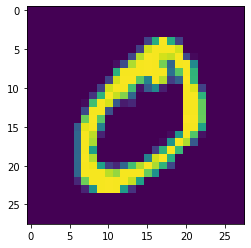

In [ ]:
plt.imshow(img1)

In [ ]:
trf = transforms.Compose([transforms.ToTensor(), 
                          transforms.Normalize((0.5,),(0.5,)),
                          #transforms.RandomErasing(p=0.5,scale=(0.01,0.1))
                          ])

In [ ]:
img_tensor = trf(img1)
plt.imshow(img_tensor[0])

In [ ]:
pil_trans = transforms.ToPILImage()

In [ ]:
p_img = pil_trans(img1)

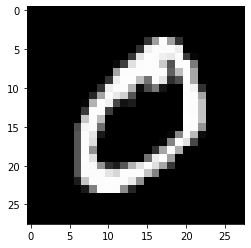

In [ ]:
plt.imshow(p_img)

In [ ]:
path = Path('data')

In [ ]:
path.absolute()

PosixPath('/content/data')

In [ ]:
mnist_tensors = path / 'mnist_tensors'

In [ ]:
trainset = datasets.MNIST(str(mnist_tensors),train=True, transform=trf,download=True)

Extracting data/mnist_tensors/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist_tensors/MNIST/raw



Extracting data/mnist_tensors/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist_tensors/MNIST/raw


Extracting data/mnist_tensors/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist_tensors/MNIST/raw


Extracting data/mnist_tensors/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist_tensors/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
valset = datasets.MNIST(str(mnist_tensors), download=True, train=False, transform=trf)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True, num_workers=0)

In [ ]:
data_iter = iter(trainloader)

In [ ]:
image_batch, labels_batch = data_iter.next()

In [ ]:
print(image_batch.shape)
print(labels_batch)
print(labels_batch.size())

torch.Size([64, 1, 28, 28])
tensor([9, 4, 1, 9, 4, 3, 3, 6, 2, 4, 5, 1, 1, 2, 9, 2, 1, 3, 7, 8, 6, 7, 1, 8,
        2, 6, 9, 7, 1, 7, 7, 6, 0, 1, 2, 4, 9, 9, 2, 5, 7, 3, 7, 2, 2, 8, 1, 1,
        9, 4, 0, 1, 5, 2, 2, 0, 1, 1, 4, 0, 8, 6, 2, 2])
torch.Size([64])


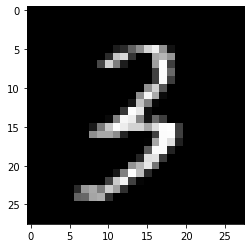

In [ ]:
plt.imshow(image_batch[5].numpy().squeeze(), cmap='gray');

In [ ]:
image_batch[5]

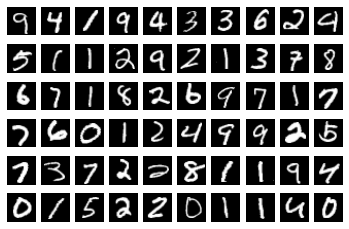

In [ ]:
figure = plt.figure()
num_of_images = 60
for i in range(0, num_of_images):
  plt.subplot(6,10,i+1)
  plt.axis('off')
  plt.imshow(image_batch[i].numpy().squeeze(),cmap='gray')

In [ ]:
nn.LogSoftmax??

In [ ]:
class FFNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(28*28,128)
    self.ac1 = nn.ReLU()
    self.fc2 = nn.Linear(128, 64)
    self.ac2 = nn.ReLU()
    self.fc3 = nn.Linear(64, 10)
    self.ac3 = nn.LogSoftmax(dim=1)
    
    self.initialize()

  def initialize(self):
    for p in self.children():
      if isinstance(p,nn.Linear):
        nn.init.xavier_normal_(p.weight)
        nn.init.zeros_(p.bias)

  
  def forward(self, x):
    out = x.view(-1, 28*28)
    out = self.fc1(out)
    out = self.ac1(out)
    out = self.fc2(out)
    out = self.ac2(out)
    out = self.fc3(out)
    out = self.ac3(out)

    return out

In [ ]:
model = FFNet()

In [ ]:
model

FFNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ac3): LogSoftmax()
)

In [ ]:
nn.NLLLoss??

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = model.to(device)

In [ ]:
from time import time

In [ ]:
model.parameters().__next__().is_cuda

True

In [ ]:
val_batch, val_labels = iter(valloader).__next__()

In [ ]:
val_batch.size()

torch.Size([64, 1, 28, 28])

In [ ]:
print(val_batch.device)
val_batch, val_labels = val_batch.to(device), val_labels.to(device)
print(val_batch.device)

cpu
cuda:0


In [ ]:
def validator(model, data_loader):
  model.eval()
  correct = 0
  total = 0
  device = torch.device('cuda' if model.parameters().__next__().is_cuda else 'cpu')
  
  for batch in data_loader:
    images, labels = batch[0], batch[1]
    images, labels = images.to(device), labels.to(device)
    #img_view = images.view(-1, 28*28)

    with torch.no_grad():
      output = model(images)
    _, predictions = torch.max(output, dim=1)
    correct += torch.sum(predictions == labels).item()
    total += labels.size(0)

  accuracy = correct/total
  return accuracy

In [ ]:
validator(model, valloader)

Validation accuracy = 0.107200


In [ ]:
def train(model, train_loader, valid_loader, validator_func, optimizer, criteria, device, epochs=5, lr=0.01):
  model.initialize()
 
  criteria_inst = criteria()
  opti = optimizer(filter(lambda p: p.requires_grad, model.parameters()), lr)

  train_loader_len = len(train_loader)

  running_loss_list = []
  loss_list = []

  for e in range(1, epochs+1):
    running_loss = 0
    model.train()
    for i, batch in enumerate(train_loader):
      images, labels = batch
      images, labels = images.to(device), labels.to(device)

      output = model(images)
      loss = criteria_inst(output, labels)
      loss.backward()
      opti.step()
      opti.zero_grad()

      running_loss += loss.item()
      loss_list.append(loss.item())
    
    running_loss_list.append(running_loss/train_loader_len)
    print(f'Epoch: {e} - Training loss: {running_loss/train_loader_len:f}')
    validator(model, valid_loader)
    print('\n')

  print('Training has finished.')
  return loss_list, running_loss_list

In [ ]:
loss_results, running_loss_results = train(model=model, 
                                           train_loader = trainloader, 
                                           valid_loader = valloader, 
                                           validator_func = validator, 
                                           optimizer = optim.RMSprop, 
                                           criteria = nn.NLLLoss, 
                                           device = device, 
                                           lr=0.01)

Epoch: 1 - Training loss: 1.687985
Validation accuracy = 0.770100


Epoch: 2 - Training loss: 0.353809
Validation accuracy = 0.933000


Epoch: 3 - Training loss: 0.277393
Validation accuracy = 0.838500


Epoch: 4 - Training loss: 0.267810
Validation accuracy = 0.925600


Epoch: 5 - Training loss: 0.244128
Validation accuracy = 0.928300


Training has finished.


In [ ]:
  def plot_loss(losses, running_losses):
    a = 0 
    plt.figure(figsize=(30,10))
    plt.subplot(121)
    plt.plot(range(len(losses[a:])), losses[a:], label='loss')
    plt.title("Loss Plot")
    plt.ylabel('loss')
    plt.legend()

    plt.subplot(122)
    plt.plot(range(len(running_losses[a:])), running_losses[a:], label='running loss')
    plt.title("Running loss")
    plt.ylabel('running loss')
    plt.legend()

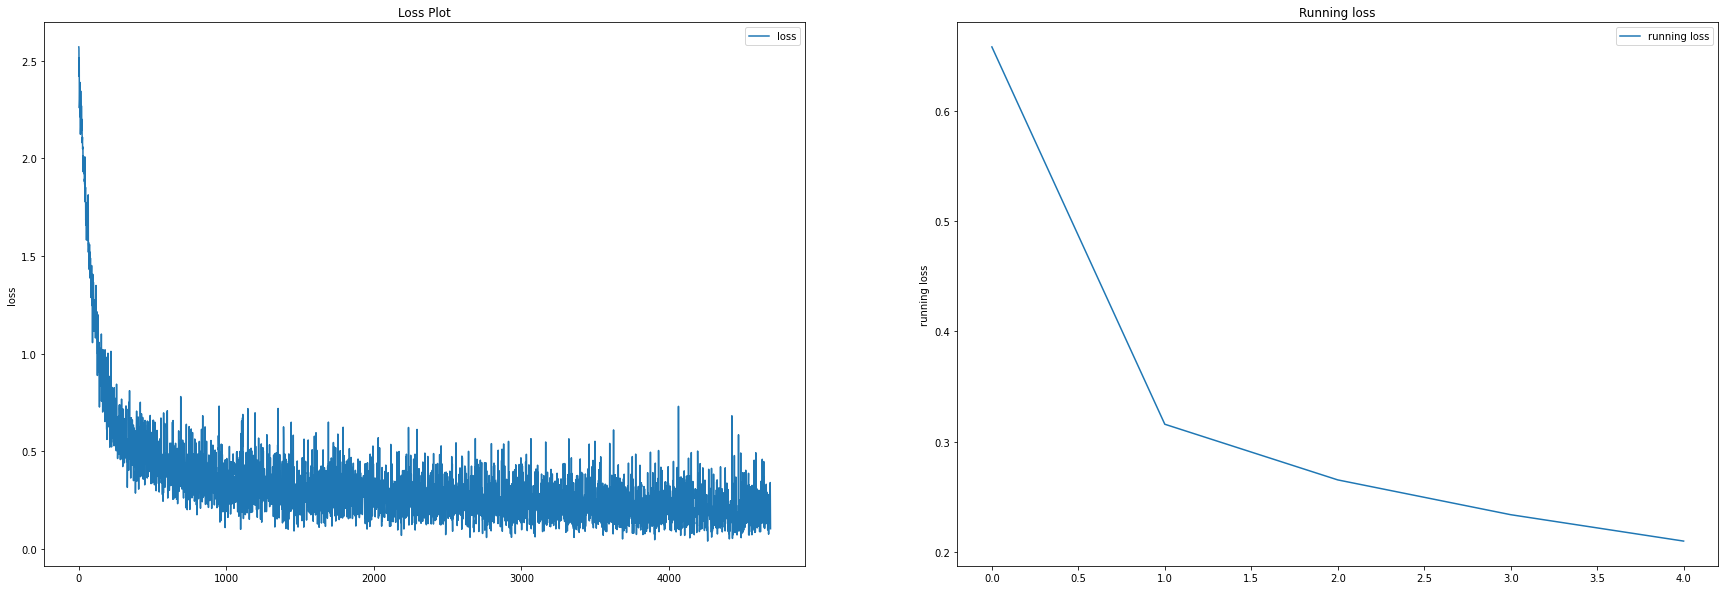

In [ ]:
plot_loss(loss_results, running_loss_results)

In [ ]:
validator(model, trainloader, train=True)
validator(model, valloader, train=False)

Train accuracy = 0.943967
Validation accuracy = 0.941300


In [ ]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class VGG_Small(nn.Module):
  def __init__(self,vgg, fine_tune = True):
    super().__init__()
    self.vgg_features = nn.Sequential(*list(vgg.features.children())[:-1])
    self.classifier = nn.Sequential(
        nn.Linear(512,10),
        #nn.ReLU(),
        #nn.Linear(100, 50),
        #nn.ReLU(),
        #nn.Linear(50, 10),
        nn.LogSoftmax(dim=1)
    )
    if fine_tune:
      self.vgg_features.requires_grad_(False)
    
    self.initialize()

  def initialize(self):
    for p in self.classifier.children():
      if isinstance(p, nn.Linear):
        nn.init.xavier_normal_(p.weight)
        nn.init.zeros_(p.bias)

  def forward(self, x):
    out = self.vgg_features(x)
    out = out.squeeze()
    out = self.classifier(out)
    return out

In [ ]:
vgg_small = VGG_Small(vgg16_model)

In [ ]:
vgg_small

VGG_Small(
  (vgg_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
vgg_small = vgg_small.to(device)

In [ ]:
class To_3_Channels(object):
  def __call__(sefl, img_tensor):
    return torch.cat((img_tensor, img_tensor, img_tensor),dim=0)

In [ ]:
my_transforms = transforms.Compose([transforms.ToTensor(), 
                          transforms.Normalize((0.5,),(0.5,)),
                          #transforms.RandomErasing(p=0.5,scale=(0.01,0.1)),
                          To_3_Channels()
                          ])

In [ ]:
train_set_3_channel = datasets.MNIST(str(mnist_tensors), train=True, transform=my_transforms, download=True)
valid_set_3_channel = datasets.MNIST(str(mnist_tensors), train=False, transform=my_transforms, download=True)

In [ ]:
trainloader_3ch = torch.utils.data.DataLoader(dataset = train_set_3_channel, batch_size=64, shuffle=True, num_workers=0)
validloader_3ch = torch.utils.data.DataLoader(dataset = valid_set_3_channel, batch_size=64, shuffle=True, num_workers=0)

In [ ]:
loss_results, running_loss_results = train(model=vgg_small, 
                                           train_loader = trainloader_3ch, 
                                           valid_loader = validloader_3ch, 
                                           validator_func = validator, 
                                           optimizer = optim.Adam, 
                                           criteria = nn.NLLLoss, 
                                           device = device,
                                           epochs = 16,
                                           lr = 0.01)

## Train model with FastAI library

In [ ]:
from fastai.basics import *

In [ ]:
import gzip
import pickle

In [ ]:
path = Path('data')

In [ ]:
mnist_fastai_path = path / 'mnist_fastai'

In [ ]:
! wget -P {mnist_fastai_path} http://deeplearning.net/data/mnist/mnist.pkl.gz

--2020-07-03 05:27:32--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist_fastai/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.08MB/s    in 6.0s    

2020-07-03 05:27:39 (2.58 MB/s) - ‘data/mnist_fastai/mnist.pkl.gz’ saved [16168813/16168813]



In [ ]:
gzip.open?

In [ ]:
pickle.load?

In [ ]:
with gzip.open(mnist_fastai_path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding='latin-1')
  

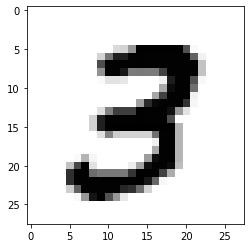

In [ ]:
plt.imshow(x_train[7].reshape((28,28)),cmap='gray_r')

In [ ]:
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(type(x_train))

(50000, 784)
(10000, 784)
(10000, 784)
<class 'numpy.ndarray'>


In [ ]:
torch.Tensor?

In [ ]:
x_train, y_train, x_valid, y_valid, x_test, y_test = [torch.from_numpy(d) for d in (x_train, y_train, x_valid, y_valid, x_test, y_test)]

In [ ]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
test_ds = TensorDataset(x_test, y_test)

In [ ]:
bs = 64
data_bunch = DataBunch.create(train_ds, valid_ds, test_ds, bs=bs, num_workers=0)

In [ ]:
x, y = next(iter(data_banch.train_dl))

In [ ]:
x.size(), y.size()

(torch.Size([64, 784]), torch.Size([64]))

In [ ]:
net = FFNet()

In [ ]:
net = nn.Sequential(nn.Linear(28 * 28, 128),
                    nn.ReLU(),
                    nn.Linear(128, 64, bias=True),
                    nn.ReLU(),
                    nn.Linear(64, 10, bias=True))

In [ ]:
net = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(28 * 28, 128)),
                        ('ac1', nn.ReLU()),
                        ('fc2', nn.Linear(128, 64, bias=True)),
                        ('ac2', nn.ReLU()),
                        ('fc3', nn.Linear(64, 10, bias=True))]))

In [ ]:
net

FFNet(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (ac1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (ac2): ReLU()
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (ac3): LogSoftmax()
)

In [ ]:
loss_func = nn.NLLLoss()

In [ ]:
learn = Learner(data_bunch, net, loss_func=loss_func, metrics=accuracy)

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


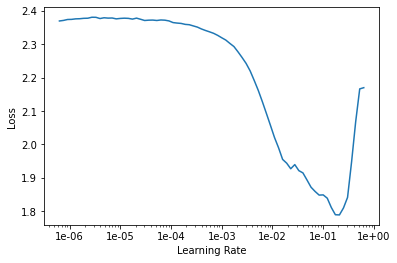

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(10,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.069925,0.124983,0.968800,00:03
1,0.130638,0.171708,0.962800,00:03
2,0.219793,0.248811,0.943700,00:04
3,0.176662,0.174558,0.958800,00:04
4,0.148002,0.177756,0.961000,00:04
5,0.132931,0.162992,0.966500,00:04
6,0.081829,0.122677,0.972100,00:05
7,0.056997,0.107343,0.974400,00:05
8,0.027110,0.104761,0.978400,00:05
9,0.019702,0.104369,0.978500,00:05


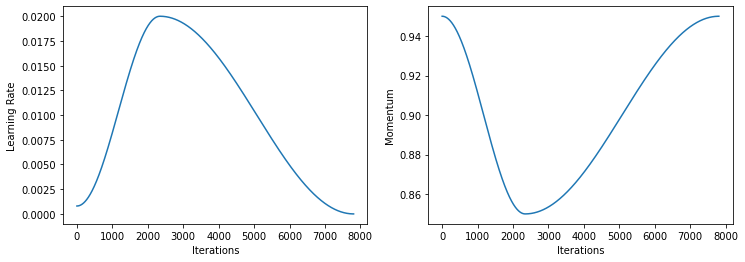

In [ ]:
learn.recorder.plot_lr(show_moms=True)

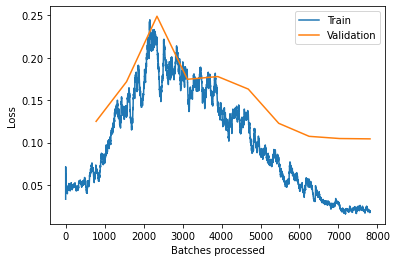

In [ ]:
learn.recorder.plot_losses()

In [ ]:
print(f'train accuracy = {validator(net, data_bunch.train_dl):f}')
print(f'valid accuracy = {validator(net, data_bunch.valid_dl):f}')
print(f'test  accuracy = {validator(net, data_bunch.test_dl):f}')

train accuracy = 0.994818
valid accuracy = 0.978500
test  accuracy = 0.978200
